In [1]:
from math import pi
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import IPython
import collections
from scipy.io.wavfile import write, read

In [2]:
def PreProcessData(xn, frameSize, stepSize):
    padding = len(xn) % stepSize
    if(padding == 0):
        temp = xn
    else:
        temp = np.append(xn, np.zeros(stepSize - padding))
    
    data = np.append(np.zeros(frameSize), temp)

    iteration = (len(data) // stepSize) - (frameSize // stepSize) + 1
    
    dataSet = np.zeros([iteration, frameSize])
    
    for i in range(iteration):
        start = i * stepSize
        end = start + frameSize
        dataSet[i] = data[start:end]
        
    return dataSet, data, len(data), iteration

In [3]:
frameSize = 4096
stepSize = 256

C:\Users\zengkuiwen\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  """Entry point for launching an IPython kernel.


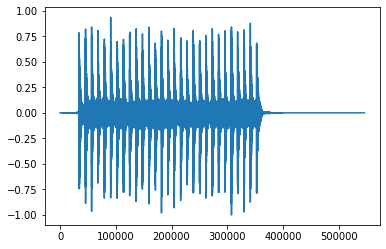

In [4]:
rate, file = read("台北帝國intro.wav")
fixed_data = file[:, 0]
float_data = fixed_data.astype(np.float32, order='C') / 32767.0

dataSet, data, length, iteration = PreProcessData(float_data, frameSize, stepSize)

plt.plot(data)
plt.show()

IPython.display.display(IPython.display.Audio("台北帝國intro.wav", rate = rate))

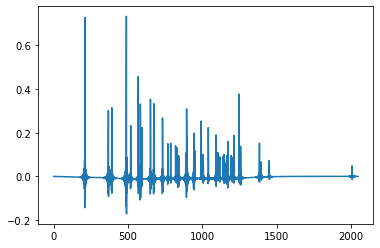

In [5]:
rir = open("impedance_1.dat")
hn = []
for element in rir.readlines():
    hn.append(float(element))

plt.plot(hn)
plt.show()

Hn = np.fft.fft(np.append(np.array(hn), np.zeros(frameSize - len(hn))))

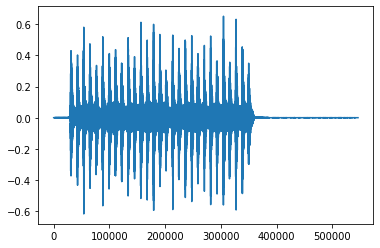

In [6]:
output = np.zeros(length)
    
for i in range(iteration):
    
    Xn = np.fft.fft(dataSet[i], frameSize)
    Yn = np.multiply(Xn, Hn)
    yn = np.fft.ifft(Yn)

    start = i * stepSize
    end = start + stepSize
    output[start:end] = yn[-stepSize:].real * 0.25

write("fft_fir_ols.wav", rate, (output * 32767.0).astype(np.int16))

plt.plot(output)
plt.show()

IPython.display.display(IPython.display.Audio("fft_fir_ols.wav", rate = rate))

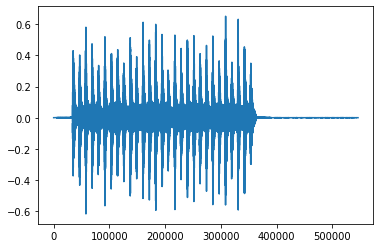

In [7]:
output = np.zeros(length)

for i in range(iteration):    
    
    xn = np.append(data[i * stepSize : (i+1) * stepSize], np.zeros(frameSize - stepSize))
    Xn = np.fft.fft(xn)
    Yn = np.multiply(Xn, Hn)
    yn = np.fft.ifft(Yn)
    
    start = i * stepSize
    end = start + frameSize
    
    output[start:end] = output[start:end] + yn.real * 0.25

write("fft_fir_ola.wav", rate, (output * 32767.0).astype(np.int16))

plt.plot(output)
plt.show()

IPython.display.display(IPython.display.Audio("fft_fir_ola.wav", rate = rate))

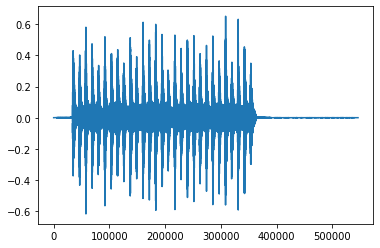

In [8]:
output = np.zeros(length)

bufferSize = int(frameSize//stepSize)
outputBuffer = collections.deque(maxlen=bufferSize)
for i in range(bufferSize):
    outputBuffer.append(np.zeros(frameSize))

for index in range(iteration):    
    
    xn = np.append(data[index * stepSize : (index+1) * stepSize], np.zeros(frameSize - stepSize))
    Xn = np.fft.fft(xn)
    Yn = np.multiply(Xn, Hn)
    yn = np.fft.ifft(Yn)
    
    start = index * stepSize
    end = start + stepSize
    
    outputBuffer.appendleft(yn.real * 0.25)
    
    for chunk in range(bufferSize):
        output[start:end] = output[start:end] + outputBuffer[chunk][chunk*stepSize : (chunk+1) * stepSize]

write("fft_fir_ola_v2.wav", rate, (output * 32767.0).astype(np.int16))


plt.plot(output)
plt.show()

IPython.display.display(IPython.display.Audio("fft_fir_ola_v2.wav", rate = rate))